# 8. 인물사진을 만들어 보자

## 필요한 library import

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [3]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
model_dir = os.getenv('HOME')+'/aiffel/exploration/ex8/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/exploration/ex8/models
model loaded successfully!


In [4]:
def blur(img_orig, label=15):
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())   
    
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == label, label, 0) 
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    img_orig_blur = cv2.blur(img_orig, (20,20)) #(13,13)은 blurring  kernel size를 뜻합니다. 
    
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    return img_concat
    

## 셀카 blur 처리하기

(720, 1280, 3) (288, 513, 3) 15


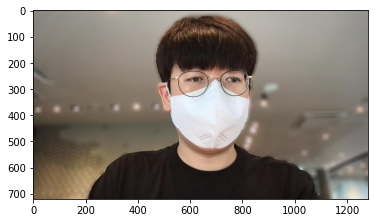

In [5]:
img_path_1 = os.getenv('HOME')+'/aiffel/exploration/ex8/data/photo_1.jpg'
img_orig = cv2.imread(img_path_1) 

blur_img = blur(img_orig)
plt.imshow(cv2.cvtColor(blur_img, cv2.COLOR_BGR2RGB))
plt.show()

## 고양이 blur 처리

(458, 600, 3) (391, 513, 3) 11


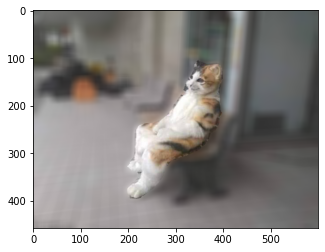

In [6]:
img_cat_path = os.getenv('HOME')+'/aiffel/exploration/ex8/data/cat.jpg'
img_cat = cv2.imread(img_cat_path) 

blur_cat_img = blur(img_cat, 8)
plt.imshow(cv2.cvtColor(blur_cat_img, cv2.COLOR_BGR2RGB))
plt.show()

## 배경 바꾸기

In [7]:
def change_bg(img_orig, img_bg):
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())   
    
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_bg, img_bg_mask)
    
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    return img_concat
    

(720, 1280, 3) (288, 513, 3) 15


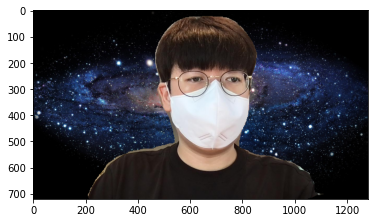

In [8]:
img_path_bg = os.getenv('HOME')+'/aiffel/exploration/ex8/data/bg_universe.jpeg'
img_bg = cv2.imread(img_path_bg) 

changed_bg_img = change_bg(img_orig, img_bg)
plt.imshow(cv2.cvtColor(changed_bg_img, cv2.COLOR_BGR2RGB))
plt.show()

## 문제점

![download.png](image/download.png)
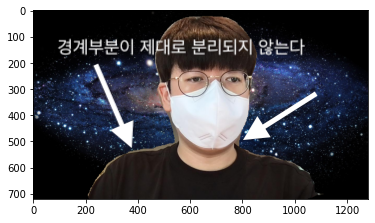

## 해결방법

<object data="http://xiaoyongshen.me/papers/deepmatting.pdf?fbclid=IwAR1y2fwg8Uogsn_v4gmk-lR5K-PMH4Bn91S5g8B1u1KAaquu-PT3_gLTd2k" type="application/pdf" width="700px" height="900px">
    <embed src="http://xiaoyongshen.me/papers/deepmatting.pdf?fbclid=IwAR1y2fwg8Uogsn_v4gmk-lR5K-PMH4Bn91S5g8B1u1KAaquu-PT3_gLTd2k">
        <p>This browser does not support PDFs. Please download the PDF to view it: <a href="http://xiaoyongshen.me/papers/deepmatting.pdf?fbclid=IwAR1y2fwg8Uogsn_v4gmk-lR5K-PMH4Bn91S5g8B1u1KAaquu-PT3_gLTd2k">Download PDF</a>.</p>
    </embed>
</object>

<object data="http://xiaoyongshen.me/webpage_portrait/papers/portrait_eg16.pdf?fbclid=IwAR2Vzxbj26egnPTJGeiWLB8W4vPB5HG2aIFzEj6QNfgkiaXvg2EV0YryEco" type="application/pdf" width="700px" height="900px">
    <embed src="http://xiaoyongshen.me/webpage_portrait/papers/portrait_eg16.pdf?fbclid=IwAR2Vzxbj26egnPTJGeiWLB8W4vPB5HG2aIFzEj6QNfgkiaXvg2EV0YryEco">
        <p>This browser does not support PDFs. Please download the PDF to view it: <a href="http://xiaoyongshen.me/webpage_portrait/papers/portrait_eg16.pdf?fbclid=IwAR2Vzxbj26egnPTJGeiWLB8W4vPB5HG2aIFzEj6QNfgkiaXvg2EV0YryEco">Download PDF</a>.</p>
    </embed>
</object>